# Dynamic Time Warping for Non-Anthropomorphic Hand Data

In [1]:
# Set up:
# %matplotlib widget
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib notebook
import pandas as pd
import numpy as np

# Plotting Packages
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

mpl.rcParams['figure.dpi'] = 150
savefig_options = dict(format="png", dpi=150, bbox_inches="tight")

# import plotly.graph_objects as go
# import plotly.express as px
# import ipywidgets as widget

# Computation packages
from scipy.spatial.distance import euclidean
from scipy.signal import find_peaks
from fastdtw import fastdtw

In [2]:
from nah.alignments import load_raw_csv_data
from nah.utils import norm_data, full_align, full_joint_align, clean_rot_data, load_npzs,segment_by_demo,sumofsquares,load_npzs

from nah.plot import plot_norm, plot_pos, plot_rot, plot_raw_data, plot_raw_data_subsampled,view_participant_robot_gesture

In [3]:
# # Functions are all defined. Let's grab some data sets and get them ordered

# robot_name = "Reachy"
# end_eff_name = "r_wrist2hand"

# robot_name = "j2s6s300"
# end_eff_name = "j2s6s300_end_effector"

# for gesture_num in range(3,4):
# #     print(gesture_num)
#     for demo_num in range(1,6):
#         print(gesture_num, demo_num)
#         end_eff_data, hand_data, camera_data, joint_data = load_raw_csv_dataobot_name,end_eff_name, PID, gesture_num, demo_num)
#         warp_path = norm_data(gesture_num, demo_num, end_eff_data, hand_data)
#         time_URDF_aligned, time_hand_aligned, end_eff_pos_aligned, end_eff_rot_aligned, hand_pos_aligned, hand_rot_aligned = \
#             full_align(warp_path, end_eff_data, hand_data)
#         hand_rot_aligned = clean_rot_data(gesture_num, demo_num, hand_rot_aligned)
#         hand_rot_aligned = clean_rot_data(gesture_num, demo_num, hand_rot_aligned) #Seems to work better if you do it twice for some reason
#         plot_pos(gesture_num, demo_num, warp_path, end_eff_pos_aligned, hand_pos_aligned)
#         plot_rot(gesture_num, demo_num, warp_path, end_eff_rot_aligned, hand_rot_aligned)
        
#         np.savez('data_PID'+str(PID)+"_"+str(robot_name)+"_gesture_"+str(gesture_num)+'_'+str(demo_num),time_URDF_aligned=time_URDF_aligned, time_hand_aligned=time_hand_aligned,\
#                 end_eff_pos_aligned=end_eff_pos_aligned, end_eff_rot_aligned=end_eff_rot_aligned, \
#                 hand_pos_aligned=hand_pos_aligned, hand_rot_aligned=hand_rot_aligned, \
#                 camera_data = camera_data, \
#                 gesture_num=gesture_num, demo_num=demo_num, warp_path=warp_path, end_eff_data=end_eff_data, hand_data=hand_data)


In [26]:
gesture_num=0
demo_num = 1

# robot_name = "Reachy"
# end_eff_name = "r_wrist2hand_"

robot_name = "j2s6s300"
end_eff_name = "j2s6s300_end_effector_"

total_end_eff_data = np.array([])
total_camera_data  = np.array([])
total_rh_data      = np.array([])
total_lh_data      = np.array([])
total_joint_data   = np.array([])

start_index = 1 
end_index = -1 
# start_index = 77
# end_index = -154

followup = False

if followup:
    PIDmax=10
    gesturemax = 7
else:
    PIDmax=17
    gesturemax=16

gest_target = 4
   

for PID in range(1,PIDmax):
# for PID in range(3,4):
    
    for gesture_num in range(1,gesturemax):
    # for gesture_num in range(gest_target,gest_target+1):
        
        for demo_num in range(1,6): # Change this to include all demos that exist (and possibly exclude individual ones)
            # print(gesture_num, demo_num)
            
            # LIST OF OVERRIDES:
            # These are robots/participants that had erroneous or incomplete data. Two cases exist:
            #  1) The user recorded a demo that they later wished to replace with an extra recording. 
            #     The robot, PID, and gesture to omit/gesture to replace must be specified.
            #     The easy way to do this would be to just grab the last five demos for each gesture,
            #     but that's not 100% accurate. It was not always the first demo that was the mess-up.
            #  2) The robot spazzed out and the user was unable to finish all gestures or motions. 
            #     I don't think we can account for that here; I think this will affect clustering, workspace 
            #     coverage, and metrics of user consistency, but that's going to show up later.
            
            if not followup:
                if robot_name[0]=='R':
                    if (PID==2 and gesture_num==1):
                        print("Correcting PID 2, gesture 1")
                        demo_num += 10  #PID2 recorded many extra motions before settling on the last five to show
                    elif (PID==9 and gesture_num==4 and demo_num==1):
                        print("Correcting PID 9, gesture 4, demo 1")
                        demo_num = 6
                    elif (PID==16 and gesture_num==11):
                        print("Correcting PID 16, gesture 11")
                        demo_num += 5
                    elif (PID==16 and gesture_num==12):
                        print("Correcting PID 16, gesture 12")
                        demo_num += 6
                elif robot_name[0]=='j':
                    if (PID==11 and gesture_num==3 and demo_num==1):
                        print("Correcting PID 11, gesture 3, demo 1")
                        demo_num = 6
                    elif (PID==12 and gesture_num==1 and demo_num==1):
                        print("Correcting PID 12, gesture 1, demo 1")
                        demo_num = 6
                    elif (PID==12 and gesture_num==4):
                        print("Correcting PID 12, gesture 4")
                        demo_num += 2
                    elif (PID==16 and gesture_num==11):
                        print("Correcting PID 16, gesture 11")
                        demo_num += 1

            print(PID, gesture_num, demo_num)
            
            try:
                end_eff_data_temp = load_raw_csv_dataobot_name,end_eff_name, PID, followup, gesture_num, demo_num)
                camera_data_temp  = load_raw_csv_data(robot_name,"Main Camera_", PID, followup, gesture_num, demo_num)
                rh_data_temp      = load_raw_csv_data(robot_name,"RightHand Controller_", PID, followup, gesture_num, demo_num)
                lh_data_temp      = load_raw_csv_data(robot_name,"LeftHand Controller_", PID, followup, gesture_num, demo_num)
                joint_data_temp   = load_raw_csv_data(robot_name,"Joint", PID, followup, gesture_num, demo_num)
    
                # I wanted to move this out of the try/catch statement, but then the variable names were out of scope
                end_eff_data_temp[:,0] = end_eff_data_temp[:,0]-end_eff_data_temp[0,0]
                camera_data_temp[:,0]  = camera_data_temp[:,0]-camera_data_temp[0,0]
                rh_data_temp[:,0]      = rh_data_temp[:,0]-rh_data_temp[0,0]
                lh_data_temp[:,0]      = lh_data_temp[:,0]-lh_data_temp[0,0]
                joint_data_temp[:,0]   = joint_data_temp[:,0]-joint_data_temp[0,0]
                
                end_eff_data_temp = end_eff_data_temp[start_index:end_index,:]
                camera_data_temp  = camera_data_temp[start_index:end_index,:]
                rh_data_temp      = rh_data_temp[start_index:end_index,:]
                lh_data_temp      = lh_data_temp[start_index:end_index,:]
                joint_data_temp   = joint_data_temp[start_index:end_index,:]
            except:
                error_message = "Import data failed for PID "+ str(PID)+", gesture "+str(gesture_num)+", demo_num "+str(demo_num)
                # raise RuntimeError(error_message)
                print(error_message)

            # More participant-specific exceptions:
            if (PID==3 and not followup):
                if (gesture_num>=3):
                    holding_variable = rh_data_temp
                    rh_data_temp = lh_data_temp
                    lh_data_temp = holding_variable
            # Normalize by participant wingspan
            # ...
           
            try:
                if (demo_num==1):
                    end_eff_data = end_eff_data_temp
                    camera_data  = camera_data_temp
                    rh_data      = rh_data_temp
                    lh_data      = lh_data_temp
                    joint_data   = joint_data_temp
                else:   
                    end_eff_data = np.vstack((end_eff_data, end_eff_data_temp))
                    camera_data  = np.vstack((camera_data, camera_data_temp))
                    rh_data      = np.vstack((rh_data, rh_data_temp))
                    lh_data      = np.vstack((lh_data, lh_data_temp))
                    joint_data  = np.vstack((joint_data, joint_data_temp))
            except:
                print("Stacking data for demo "+str(demo_num)+" failed")
    
            try:
                if followup:
                    np.savez('C:\\Users\\jmoln\\Dropbox (GaTech)\\Non-Anthropomorphic Hands User Study Data\\npz files\\data_PID'+str(PID)+"B_"+str(robot_name)+"_gesture_"+str(gesture_num),\
                             end_eff_data=end_eff_data,rh_data=rh_data,lh_data=lh_data,\
                             camera_data=camera_data,joint_data=joint_data)
                else:
                    np.savez('C:\\Users\\jmoln\\Dropbox (GaTech)\\Non-Anthropomorphic Hands User Study Data\\npz files\\data_PID'+str(PID)+"_"+str(robot_name)+"_gesture_"+str(gesture_num),\
                             end_eff_data=end_eff_data,rh_data=rh_data,lh_data=lh_data,\
                             camera_data=camera_data,joint_data=joint_data)
   
            except: 
                print("Save data failed")

        # try:    
        #     if ((PID==1) & (gesture_num==gest_target)):
        #         total_end_eff_data = end_eff_data
        #         total_camera_data = camera_data
        #         total_rh_data     = rh_data
        #         total_lh_data     = lh_data
        #         total_joint_data  = joint_data
        #     else:
        #         total_end_eff_data = np.vstack((total_end_eff_data,end_eff_data))
        #         total_camera_data  = np.vstack((total_camera_data,camera_data))
        #         total_rh_data      = np.vstack((total_rh_data,rh_data))
        #         total_lh_data      = np.vstack((total_lh_data,lh_data))
        #         total_joint_data   = np.vstack((total_joint_data,joint_data))
        # except:
        #     print("Data was missing from PID"+str(PID)+" gesture "+str(gesture_num))

# plot_raw_data(total_end_eff_data, total_rh_data, total_lh_data, total_camera_data, total_joint_data, start_index, end_index)


1 1 1
1 1 2
1 1 3
1 1 4
1 1 5
1 2 1
1 2 2
1 2 3
1 2 4
1 2 5
1 3 1
1 3 2
1 3 3
1 3 4
1 3 5
1 4 1
1 4 2
1 4 3
1 4 4
1 4 5
1 5 1
1 5 2
1 5 3
1 5 4
1 5 5
1 6 1
1 6 2
1 6 3
1 6 4
1 6 5
1 7 1
1 7 2
1 7 3
1 7 4
1 7 5
1 8 1
1 8 2
1 8 3
1 8 4
1 8 5
1 9 1
1 9 2
1 9 3
1 9 4
1 9 5
1 10 1
1 10 2
1 10 3
1 10 4
1 10 5
1 11 1
1 11 2
1 11 3
1 11 4
1 11 5
1 12 1
1 12 2
1 12 3
1 12 4
1 12 5
1 13 1
1 13 2
1 13 3
1 13 4
1 13 5
1 14 1
1 14 2
1 14 3
1 14 4
1 14 5
Import data failed for PID 1, gesture 14, demo_num 5
1 15 1
Import data failed for PID 1, gesture 15, demo_num 1
1 15 2
Import data failed for PID 1, gesture 15, demo_num 2
1 15 3
Import data failed for PID 1, gesture 15, demo_num 3
1 15 4
Import data failed for PID 1, gesture 15, demo_num 4
1 15 5
Import data failed for PID 1, gesture 15, demo_num 5
2 1 1
2 1 2
2 1 3
2 1 4
2 1 5
2 2 1
2 2 2
2 2 3
2 2 4
2 2 5
2 3 1
2 3 2
2 3 3
2 3 4
2 3 5
2 4 1
2 4 2
2 4 3
2 4 4
2 4 5
2 5 1
2 5 2
2 5 3
2 5 4
2 5 5
2 6 1
2 6 2
2 6 3
2 6 4
2 6 5
2 7 1
2 7 2
2 7 3
2 7 

100%|██████████| 1/1 [00:00<00:00, 164.48it/s]


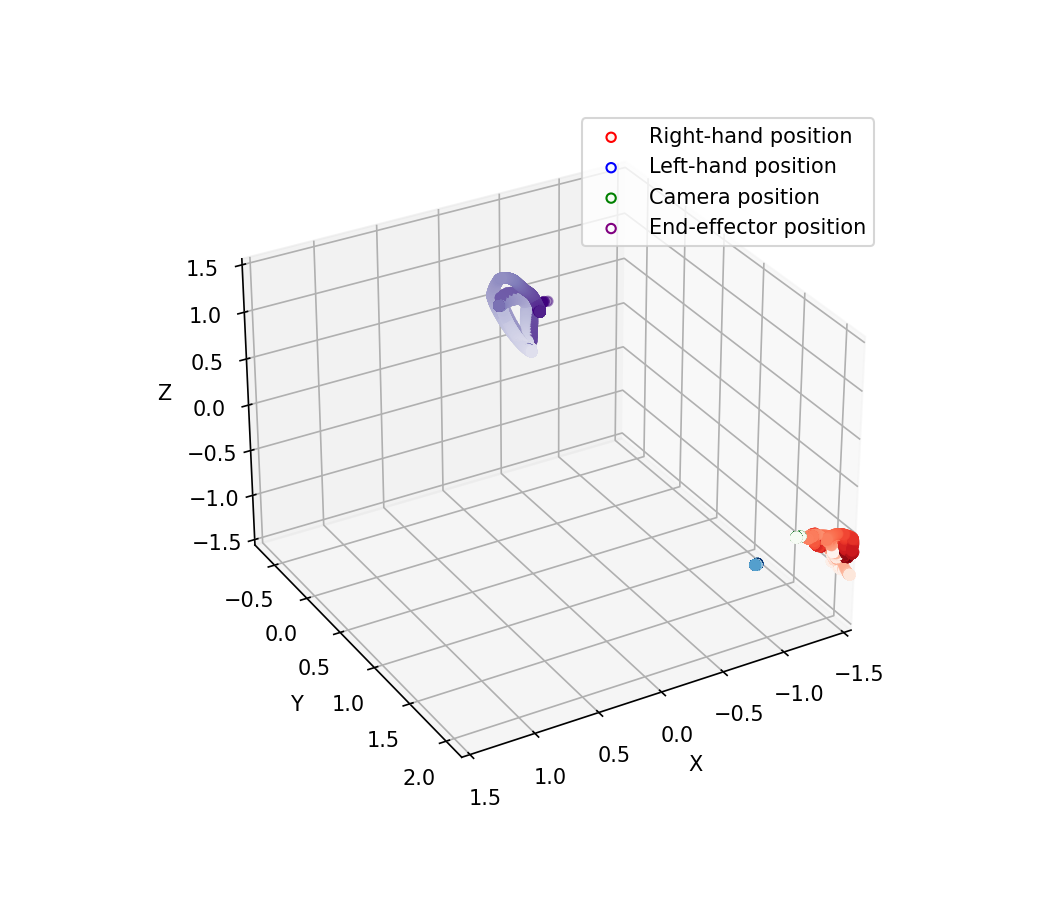

In [5]:
%matplotlib widget
# robot_name='j2s6s300'
robot_name='Reachy'
singlePID=True
singlePIDval = 16
gesture_num=12
followup = False

view_participant_robot_gesture(robot_name,singlePIDval,gesture_num,followup,singlePID)

In [18]:
## SCRATCHPAD STUFF BEGINS HERE
demo_max=2

peaks, _ = find_peaks(end_eff_data[:,0], height=0)

end_eff_data, camera_data, rh_data, lh_data, joint_data = load_npzs(robot_name, PID, followup, gesture_num)

end_eff_multi_demo, camera, rh, lh, joints = segment_by_demo(end_eff_data, camera_data, rh_data, lh_data, joint_data, demo_max)
# end_eff = np.array(end_eff)
# temp = norm_data(sumofsquares(rh[0]),sumofsquares(rh[1]))
# temp = norm_data(sumofsquares(end_eff[0]),sumofsquares(end_eff[1]))
temp = norm_data(sumofsquares(end_eff[0]),sumofsquares(rh[0]))
    # ax.set_title("DTW Alignment of Hand and URDF End-Effector Orientation", fontsize=20, fontweight="bold")
# plt.savefig('DTW_UnitTest.png')
    # plt.close('all')

In [20]:
print(len(end_eff_multi_demo))
print(end_eff_multi_demo[0].shape)
print(end_eff_multi_demo[1].shape)

2
(344, 7)
(346, 7)


In [21]:
    # Ideally, also need to normalize by participant height (wingspan)
    # And clip ends (~1sec at beginning, 2sec at end (but DTW should help with this))
    # np.where(time_hand_aligned>time_hand_aligned[0]+1)[0][0]

In [22]:
try:
    warp_path = norm_data(sumofsquares(end_eff,0), sumofsquares(end_eff,1))
except:
    print("Warp data failed")
try:
    time_URDF_aligned, time_hand_aligned, end_eff_pos_aligned, end_eff_rot_aligned, hand_pos_aligned, hand_rot_aligned = \
        full_align(warp_path, end_eff_data, hand_data)
    hand_rot_aligned = clean_rot_data(gesture_num, demo_num, hand_rot_aligned)
    hand_rot_aligned = clean_rot_data(gesture_num, demo_num, hand_rot_aligned) #Seems to work better if you do it twice for some reason
except:
    print("Align data failed")
try:
    plot_pos(gesture_num, demo_num, warp_path, end_eff_pos_aligned, hand_pos_aligned, time_URDF_aligned, time_hand_aligned)
    plot_rot(gesture_num, demo_num, warp_path, end_eff_rot_aligned, hand_rot_aligned)
except:
    print("Plot data failed")

Warp data failed
Align data failed
Plot data failed


In [23]:
warp_path = norm_data(sumofsquares(rh,0), sumofsquares(rh,1))

TypeError: sumofsquares() takes 1 positional argument but 2 were given

In [ ]:
end_eff.shape

In [ ]:
temp1=sumofsquares(end_eff,0)
temp2=sumofsquares(end_eff,1)
# warp_path = norm_data(temp1,temp2)

In [ ]:
fig, ax = plt.subplots(figsize=(6,2))
fig.patch.set_visible(True)
ax.axis('on')
# ax = plt.axes(projection='3d')  
# ax.view_init(30,60)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

peaks, _ = find_peaks(end_eff_data[:,0], height=0)
ax.plot(end_eff_data[:,0])
ax.scatter(peaks,end_eff_data[peaks,0])

demo_max=2
end_eff=['']*demo_max
rh     =['']*demo_max
lh     =['']*demo_max
joints =['']*demo_max

for i in range(0,demo_max):
    if i==0:
        end_eff[i] = end_eff_data[1:peaks[0],:]
        rh[i]      =      rh_data[1:peaks[0],:]
        lh[i]      =      lh_data[1:peaks[0],:]
        joints[i]  =   joint_data[1:peaks[0],:]
    else:
        end_eff[i] = end_eff_data[peaks[i-1]:peaks[i],:]
        rh[i]      =      rh_data[peaks[i-1]:peaks[0],:]
        lh[i]      =      lh_data[peaks[i-1]:peaks[0],:]
        joints[i]  =   joint_data[peaks[i-1]:peaks[0],:]


In [ ]:
fig, ax = plt.subplots(figsize=(6,2))
fig.patch.set_visible(True)
ax.axis('on')
ax.plot(end_eff[0][:,0],end_eff[0][:,1],label="X pos")
ax.plot(end_eff[0][:,0],end_eff[0][:,2],label="Y pos")
ax.plot(end_eff[0][:,0],end_eff[0][:,3],label="Z pos")
ax.plot(end_eff[0][:,0],end_eff[0][:,4],label="X rot")
ax.plot(end_eff[0][:,0],end_eff[0][:,5],label="Y rot")
ax.plot(end_eff[0][:,0],end_eff[0][:,6],label="Z rot")

ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_visible(True)
ax.axis('on')

ax = plt.axes(projection='3d')

ax.scatter(ja_data_aligned[...,2], ja_data_aligned[...,3], ja_data_aligned[...,4], \
          c=time_ja_aligned/max(time_ja_aligned), cmap='Reds', label='Joint Angle Values')
ax.scatter(hand_data_aligned[...,0]   , -hand_data_aligned[...,2]   , hand_data_aligned[...,1]   , \
          c=time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand position')

for [map_x, map_y] in warp_path_ja: 
    ax.plot3D([ja_data_aligned[map_x].T[2], hand_data_aligned[map_y].T[0]], \
              [ja_data_aligned[map_x].T[3], -hand_data_aligned[map_y].T[2]],\
              [ja_data_aligned[map_x].T[4], hand_data_aligned[map_y].T[1]], \
              '--k', linewidth=0.2)
    
ax.set_xlabel('Horizontal position')
ax.set_ylabel('Forward/Back position')
ax.set_zlabel('Vertical position')

ax.set_title("DTW Alignment of Hand Position and First Three URDF Joint Angles", fontsize=10, fontweight="bold")


In [ ]:
PID=1
gesture_num=1
demo_num = 1

end_eff_data, camera_data, rh_data, lh_data, joint_data = load_raw_csv_data(robot_name,end_eff_name, False, PID, gesture_num, demo_num)
# jointangle_data  = dtw_jointangles_import(gesture_num, demo_num)

hand_data[...,0]=hand_data[...,0]-min(hand_data[...,0])
joint_data[...,0]=joint_data[...,0]-min(joint_data[...,0])

dtw_distance, warp_path_ja = fastdtw(joint_data[...,0], hand_data[...,0], dist=euclidean) 

time_ja    = joint_data[...,0]
time_hand  = hand_data[...,0]

wp_size             = len(warp_path_ja)
time_ja_aligned     = np.zeros(wp_size)
time_hand_aligned   = np.zeros(wp_size)
ja_data_aligned     = np.zeros((wp_size,14))
hand_data_aligned   = np.zeros((wp_size,7))

for i, [map_x, map_y] in enumerate(warp_path_ja, start=0):   
    time_ja_aligned[i]   = time_ja[map_x]
    time_hand_aligned[i] = time_hand[map_y]
    ja_data_aligned[i]      = joint_data[map_x][:]
    hand_data_aligned[i]  = hand_data[map_y]
    
np.savez('ja_data_'+str(gesture_num)+'_'+str(demo_num),time_ja_aligned=time_ja_aligned, time_hand_aligned=time_hand_aligned,\
                hand_data_aligned=hand_data_aligned, ja_data_aligned=ja_data_aligned,gesture_num=gesture_num, demo_num=demo_num, warp_path=warp_path_ja)

In [ ]:
robot_name = "Reachy"
end_eff_name = "r_wrist2hand"

# robot_name = "j2s6s300"
# end_eff_name = "j2s6s300_end_effector"
PID = 0

for gesture_num in range(1,13):
#     print(gesture_num)
    fig, ax = plt.subplots(figsize=(15, 10))
    fig.patch.set_visible(True)
    ax.axis('on')

    ax = plt.axes(projection='3d')
    
    # for [map_x, map_y] in warp_path: 
    #     ax.plot3D([end_eff_pos_aligned[map_x].T[0], hand_pos_aligned[map_y].T[0]], \
    #               [end_eff_pos_aligned[map_x].T[2], -hand_pos_aligned[map_y].T[2]],\
    #               [end_eff_pos_aligned[map_x].T[1], hand_pos_aligned[map_y].T[1]], \
    #               '--k', linewidth=0.2)
   
    for demo_num in range(1,6):     
        data = np.load('data_PID'+str(PID)+"_"+str(robot_name)+"_gesture_"+str(gesture_num)+'_'+str(demo_num)+".npz")
        hand_pos_aligned = data['hand_pos_aligned'];
        end_eff_pos_aligned = data['end_eff_pos_aligned'];
        time_hand_aligned = data['time_hand_aligned']
        
        index = np.where(time_hand_aligned>time_hand_aligned[0]+1)[0][0]
        
        end_eff_pos_aligned = end_eff_pos_aligned - end_eff_pos_aligned[index];
        hand_pos_aligned = hand_pos_aligned - hand_pos_aligned[index];

        ax.scatter(end_eff_pos_aligned[...,0], end_eff_pos_aligned[...,2], end_eff_pos_aligned[...,1], \
                  c=1-time_hand_aligned/max(time_hand_aligned), cmap='Reds', label='Joint Angle Values')
        ax.scatter(hand_pos_aligned[...,0]   , -hand_pos_aligned[...,2]   , hand_pos_aligned[...,1]   , \
                  c=1-time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand position')

        print(gesture_num, demo_num)

    ax.set_xlabel('Horizontal position')
    ax.set_ylabel('Forward/Back position')
    ax.set_zlabel('Vertical position')
    ax.legend()

    ax.set_title("Raw RH Motion Data and URDF End-Effector Position", fontsize=20, fontweight="bold")
    # plt.savefig('Raw_visuals_'+robot_name+'_gesture'+str(gesture_num)+'.png')
    plt.close('all')



In [ ]:
#import cmasher as cmr

robot_name = "Reachy"
end_eff_name = "r_wrist2hand"
PID = 0

gesture_max = 13; #This stops the plots at 12, because gesture 13 only has 4 gestures (fix this in Unity)
cmap = plt.get_cmap('plasma')
#colors = cmr.take_cmap_colors('inferno', gesture_max)
slicedCM = cmap(np.linspace(0, 1, gesture_max)
c=slicedCM[Subjects.index(Subject)]


for gesture_num in range(1,13):
#     print(gesture_num)
    fig, ax = plt.subplots(figsize=(15, 10))
    fig.patch.set_visible(True)
    ax.axis('on')

    ax = plt.axes(projection='3d')
    
    # for [map_x, map_y] in warp_path: 
    #     ax.plot3D([end_eff_pos_aligned[map_x].T[0], hand_pos_aligned[map_y].T[0]], \
    #               [end_eff_pos_aligned[map_x].T[2], -hand_pos_aligned[map_y].T[2]],\
    #               [end_eff_pos_aligned[map_x].T[1], hand_pos_aligned[map_y].T[1]], \
    #               '--k', linewidth=0.2)
    
    for demo_num in range(1,6):     
        data = np.load('data_PID'+str(PID)+"_"+str(robot_name)+"_gesture_"+str(gesture_num)+'_'+str(demo_num)+".npz")
        hand_pos_aligned = data['hand_pos_aligned'];
        end_eff_pos_aligned = data['end_eff_pos_aligned'];
        time_hand_aligned = data['time_hand_aligned']
        
        index = np.where(time_hand_aligned>time_hand_aligned[0]+1)[0][0]
        
        end_eff_pos_aligned = end_eff_pos_aligned - end_eff_pos_aligned[index];
        hand_pos_aligned = hand_pos_aligned - hand_pos_aligned[index];

        ax.scatter(end_eff_pos_aligned[...,0], end_eff_pos_aligned[...,2], end_eff_pos_aligned[...,1], \
                  c=1-time_hand_aligned/max(time_hand_aligned), cmap='Reds', label='Joint Angle Values')
        ax.scatter(hand_pos_aligned[...,0]   , -hand_pos_aligned[...,2]   , hand_pos_aligned[...,1]   , \
                  c=1-time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand position')

#         print(gesture_num, demo_num)

    ax.set_xlabel('Horizontal position')
    ax.set_ylabel('Forward/Back position')
    ax.set_zlabel('Vertical position')
    ax.legend()

    ax.set_title("Raw RH Motion Data and URDF End-Effector Position", fontsize=20, fontweight="bold")
    plt.savefig('Raw_visuals_gesture'+str(gesture_num)+'.png')
    plt.close('all')

In [ ]:
rh_data

In [ ]:
np.where(time_hand_aligned>time_hand_aligned[0]+1)[0][0]